**Run the following two cells before you begin.**

In [80]:
%autosave 10

Autosaving every 10 seconds


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

**First, import the cleaned data set. Then, select the features from the DataFrame of the case study data.**
    
These features should be: `'LIMIT_BAL'`, `'EDUCATION'`, `'MARRIAGE'`, `'AGE'`, `'PAY_1'`, `'BILL_AMT1'`, `'BILL_AMT2'`, `'BILL_AMT3'`, `'BILL_AMT4'`, `'BILL_AMT5'`, `'BILL_AMT6'`, `'PAY_AMT1'`, `'PAY_AMT2'`, `'PAY_AMT3'`, `'PAY_AMT4'`, `'PAY_AMT5'`, AND `'PAY_AMT6'`.

In [82]:
# Import data set
df=pd.read_csv('C:/Users/HP/Desktop/Datascience/Data_Exploration_and_Cleaning/cleaned_data.csv')

In [83]:
# Create features list
features_list = ['LIMIT_BAL','EDUCATION','MARRIAGE','AGE','PAY_1','BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
X = df.loc[:,features_list]
y = df['default payment next month']

_____________________________________________________
**Next, make a 80:20 train/test split using a random seed of 24.**

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)

_____________________________________________________
**Then, instantiate the `MinMaxScaler` to scale the data.**

In [85]:
scaler=MinMaxScaler().fit(X,y)
scaler1=MinMaxScaler().fit(X)
x=scaler1.transform(X)

_____________________________________________________
**Next, instantiate a logistic regression model with the `saga` solver, L1 penalty, and set `max_iter` to 1,000 as we want the solver to have enough iterations to find a good solution.**

In [86]:
lg = LogisticRegression(solver = 'saga', penalty = 'l1', max_iter = 1000)

_____________________________________________________
**Next, import the `Pipeline` class and create a `Pipeline` with the scaler and the logistic regression model, using the names `'scaler'` and `'model'` for the steps, respectively.**

In [87]:
from sklearn.pipeline import Pipeline
pipeline=Pipeline(steps=[('scaler',scaler),('model',lg)])
pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(max_iter=1000, penalty='l1',
                                    solver='saga'))])

_____________________________________________________
**Now, use the `get_params` method to view the parameters from each stage of the pipeline.**

In [88]:
# Use `get_params`
pipeline.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(max_iter=1000, penalty='l1',
                                    solver='saga'))])>

**Use the `set_params` method to change the the `model__C` parameter to 2.**

In [89]:
# View what `model__C` is set to currently
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [90]:
# Change `model__C` to 2
pipeline.set_params(model__C = 2)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=2, max_iter=1000, penalty='l1',
                                    solver='saga'))])

_____________________________________________________
**Then, create a smaller range of C values to test with cross-validation, as these models will take longer to train and test with more data than our previous activities.**

**Use C_vals = [$10^2$, $10$, $1$, $10^{-1}$, $10^{-2}$, $10^{-3}$].**


<details>
    <summary>Hint:</summary>
    Recall that exponents in Python use the ** operator.
</details>

In [91]:
C_val_exponents = np.linspace(2,-3,6)
C_vals = np.float(10)**C_val_exponents
C_vals

array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

Now, define `k_folds` using `StratifiedKFold`. The number of folds should be 4. Set the random state to 1.

In [92]:
from sklearn.model_selection import StratifiedKFold
k_folds = StratifiedKFold(n_splits = 4, random_state = 1)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


_____________________________________________________
**Next, make a new version of the `cross_val_C_search` function, called `cross_val_C_search_pipe`. Instead of the model argument, this function will take a pipeline argument. The changes inside the function will be to set the `C` value using `set_params(model__C = <value you want to test>)` on the pipeline, replacing the model with the pipeline for the fit and `predict_proba` methods, and accessing the `C` value using `pipeline.get_params()['model__C']` for the printed status update.**

In [93]:
def cross_val_C_search_pipe(k_folds, C_vals, model, X, y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)
    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        model.C = C_vals[c_val_counter]
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = y[train_index], y[test_index]
            #Fit the model on the training data
            model.fit(X_cv_train, y_cv_train)
            #Get the training ROC AUC
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            #Get the testing ROC AUC
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            #Increment the fold counter
            fold_counter += 1
            #Indicate progress
        print('Done with C = {}'.format(model.C))
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc



cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals, pipeline, x, y)

                        

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


____________________________________________________
**Now, run this function as in the previous activity, but using the new range of `C` values, the pipeline you created, and the features and response variable from the training split of the case study data.**

    You may see warnings here, or in later steps, about the non-convergence of the solver; you could experiment with the `tol` or `max_iter`` options to try and achieve convergence, although the results you obtain with `max_iter = 1000` are likely to be sufficient.

In [94]:
c_vals = [1000,10,0.0001]
def cross_val_C_search_pipe(k_folds, C_vals, model, X, y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)
    for c_val_counter in range(len(c_vals)):
        #Set the C value for the model object
        model.C = c_vals[c_val_counter]
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = y[train_index], y[test_index]
            #Fit the model on the training data
            model.fit(X_cv_train, y_cv_train)
            #Get the training ROC AUC
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            #Get the testing ROC AUC
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            #Increment the fold counter
            fold_counter += 1
            #Indicate progress
        print('Done with C = {}'.format(model.C))
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc


cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, c_vals, pipeline, x, y)

Done with C = 1000
Done with C = 10
Done with C = 0.0001


_____________________________________________________
**Plot the average training and testing ROC AUC across folds, for each `np.log(C_vals)` value.**

ValueError: x and y must have same first dimension, but have shapes (6,) and (3,)

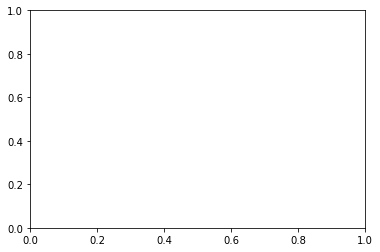

In [95]:
for this_fold in range(4):
    plt.plot(C_val_exponents, cv_train_roc_auc[this_fold], '-o', label='Training fold {}'.format(this_fold+1))
    plt.plot(C_val_exponents, cv_test_roc_auc[this_fold], '-x', label='Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc = [1.1, 0.2])
plt.title('Cross validation scores for each fold')

_____________________________________________________
**Up next, create interaction features for the case study data using scikit-learn's `PolynomialFeatures`. You should use 2 as the degree of polynomial features. Confirm that the number of new features makes sense.**

In [ ]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')

_____________________________________________________
**Finally, repeat the cross-validation procedure and observe the model performance now.**

In [ ]:
# Using the new features, make a 80:20 train/test split using a random seed of 24.**
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [ ]:
# Call the cross_val_C_search_pipe() function using the new training data.
# All other parameters should remain the same.
# Note that this training may take a few minutes due to the larger number of features.
t = poly_features.fit(X,y)
xx = poly_features.fit(X).transform(X)
Pipeline = Pipeline(steps=[('t', t), ('model', lr)])
Pipeline

In [ ]:
# Plot the average training and testing ROC AUC across folds, for each C value.
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')

**Take a look at the above graph. Does the average cross-validation testing performance improve with the interaction features? Is regularization useful?**